# UCDP GED Conflict Analysis for Kenya

UCDP GED data comes as a csv file of single conflict events for many different countries. The present notebook aims at investigating the conflict characteristics for Kenya and the study area in North-West Kenya.

## Settings

In [ ]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import matplotlib as mpl
from cycler import cycler
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
import datetime
import math

In [ ]:
# setting paths
path_conflict =#path to conflict data
path_figs = #path to figures
path_adm = #path to administrative boundaries

In [ ]:
#Figure style
tw_pt = 500.484
tw_inch = tw_pt/72.27/2
mpl.rc('figure', titlesize=11, labelsize=10, figsize=[6,4])
mpl.rc('axes', titlesize=11, labelsize=10)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
colour_rng=['teal', 'salmon', 'lightblue', 'silver', 'darkseagreen', 'palevioletred', 'slategray']
mpl.rcParams['axes.prop_cycle'] = cycler(color=colour_rng)

## Import Data

In [ ]:
#import UCDP-GED data
df_ucdp_ged = pd.read_csv(os.path.join(path_conflict, 'raw','GEDEvent_v22_1.csv'), parse_dates=['date_start', 'date_end']) 

C:\Users\gasten\AppData\Local\Temp\ipykernel_2116\1838988477.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ucdp_ged = pd.read_csv(os.path.join(path_conflict, 'raw','GEDEvent_v22_1.csv'), parse_dates=['date_start', 'date_end'])


In [ ]:
#display column names
display(df_ucdp_ged.columns)

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='object')

## Filtering

The data is filtered to only contain any non-state conflict which is clearly assignable to 
(1) a current admin-1 level unit
(2) a month

In [ ]:
#crop dataset to spatial and temporal range of interest
years = np.arange(2004, 2022) # time period of analysis
adm_0 = ['Kenya']
adm_1_SA = ['Marsabit', 'West Pokot', 'Turkana'] #study area
df_Kenya = df_ucdp_ged[(df_ucdp_ged.country.isin(adm_0)) & (df_ucdp_ged.year>=years[0])]

### Analysis of different administrative units for different time periods

Administrative units of Kenya have changed on 4th March 2013. The former admin-1 units have been 6 provinces; now it is 46 counties + Nairobi city county. These counties are equivalent to the former 46 districts of Kenya (admin-2 level) prior to 2003, but there have been a lot of temporal districts introduced, which were later decided to be illegal. 

In [ ]:
#split dataset into conflict occurring before and after change of administrative units
df_Kenya_old = df_Kenya[df_Kenya.date_start<='2013-03-03']
df_Kenya_new = df_Kenya[df_Kenya.date_start>'2013-03-03']

As the predictor variables in the DataCube are based on static administrative units based on GADM version 3.6., all conflict events need to be mapped to the current county level. As most former admin-2 levels correspond to the current admin-1 levels, the two can be combined where some temporary districts which do not exist anymore required more inquiry into the corresponding present admin-1 level.

In [ ]:
df_Kenya_old.adm_2.unique()

array(['Nairobi district', 'Mandera district', 'Lamu district', nan,
       'Garissa district', 'Mombasa district', 'Migori district',
       'Siaya district', 'Homa Bay district', 'Trans Nzoia district',
       'Kisumu district', 'Nakuru district', 'Machakos district',
       'Muranga district', 'Kiambu district', 'Kwale district',
       'Bungoma district', 'Kakamega district', 'Mt. Elgon district',
       'Uasin Gishu district', 'Turkana district', 'Narok district',
       'Kirinyaga district', 'Wajir district', 'Laikipia district',
       'Kericho district', 'West Pokot district', 'Baringo district',
       'Isiolo district', 'Marsabit district', 'Moyale district',
       'Samburu district', 'Meru North district', 'Tana River district'],
      dtype=object)

In [ ]:
df_Kenya_new.adm_1.unique()

array(['Garissa county', 'Nairobi city county', 'Kwale county',
       'Mandera county', 'Lamu county', 'Tana River county',
       'Mombasa county', 'Wajir county', 'Marsabit county',
       'Kisumu county', 'Siaya county', 'Laikipia county', nan,
       'Homa Bay county', 'Migori county', 'Elgeyo Marakwet county',
       'Meru county', 'Kericho county', 'Kilifi county', 'Narok county',
       'Kiambu county', 'Kitui county', 'Bungoma county', 'Kisii county',
       'Uasin Gishu county', 'Kakamega county', 'Nandi county',
       'Turkana county', 'West Pokot county', 'Samburu county',
       'Baringo county', 'Isiolo county'], dtype=object)

Overview of the former admin-2 levels and their current corresponding admin-1 levels:

|Former district|Corresponding current county|
|---|---|
|Nairobi district|Nairobi city county|
|Mandera district|Mandera county|
|Lamu district|Lamu county|
|Garissa district|Garissa county|
|Mombasa district|Mombasa county|
|Moyale district|Marsabit county|
|Migori district|Migori county|
|Siaya district|Siaya county|
|Homa Bay district|Homa Bay county|
|Kiambu district|Kiambu county|
|Nakuru district|Nakuru county|
|Trans Nzoia district|Trans Nzoia county|
|Kisumu district|Kisumu county|
|Machakos district|Machakos county|
|Murang'a district|Murang'a county|
|Kwale district|Kwale county|
|Bungoma district|Bungoma county|
|Kakamega district|Kakamega county|
|Mt. Elgon district|Bungoma county|
|Uasin Gishu district|Uasin Gishu county|
|Turkana district|Turkana county|
|Narok district|Narok county|
|Kirinyaga district|Kirinyaga county|
|Wajir district|Wajir county|
|Laikipia district|Laikipia county|
|Baringo district|Baringo county|
|Kericho district|Kericho county|
|Samburu district|Samburu county|
|West Pokot district|West Pokot county|
|Isiolo district|Isiolo county|
|Tana River district|Tana River county|
|Marsabit district|Marsabit county|
|Meru North district|Meru county|

All former admin2 levels can be clearly mapped to a current admin1 level. Therefore, any conflict event which can be clearly mapped to a former admin2 level, is of sufficient spatial precision

### Analysis of spatial and temporal precision

The data comes with a spatial and temporal precision code. Some of the data cannot be clearly assigned to a month-admin1 level. That is, all data with a temporal precision code of 5 and all data with a lower temporal precision code where the time period overlaps more than one month. For the spatial precision code, all data with a precision code higher than three needs to be removed for the time prior to 4th March 2013 (as data is assigned to the admin2 level) and all data with a precision code higher than four needs to be used for the time after 2013 (as data is assigned to the admin1 level).

In [ ]:
#spatial analysis
count_prec_old = df_Kenya_old.groupby('where_prec').size()
count_prec_new = df_Kenya_new.groupby('where_prec').size()
perc_prec_old = count_prec_old/count_prec_old.sum()
perc_prec_new = count_prec_new/count_prec_new.sum()

In [ ]:
print(f"Based on the time-dependent spatial exclusion criterion prior to 2013-03-03, {(perc_prec_old[perc_prec_old.index>=4].sum()/perc_prec_old.sum() * 100):.2f}% of the data is removed and after 2013-03-03 {(perc_prec_new[perc_prec_new.index>=5].sum()/perc_prec_old.sum() * 100):.2f}% of the data is removed."
)

Based on the time-dependent spatial exclusion criterion prior to 2013-03-03, 8.16% of the data is removed and after 2013-03-03 8.33% of the data is removed.


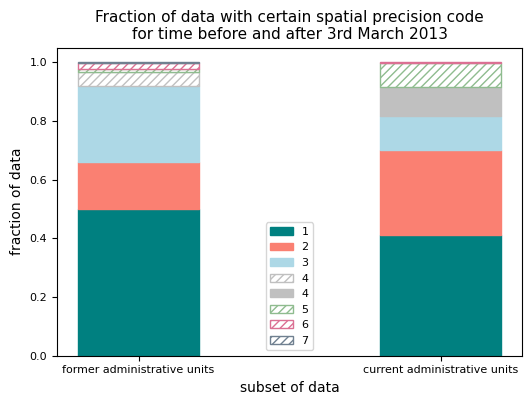

In [ ]:
#figure of data per spatial precision code for before and after 2013
plt.figure(figsize=[6,4])
sum_old = 0
sum_new = 0
for i in perc_prec_old.index:
    if i <=3:
        plt.bar(1, perc_prec_old.loc[i], bottom=sum_old, color=colour_rng[i-1], edgecolor=colour_rng[i-1], width=0.4)
    else:
        plt.bar(1, perc_prec_old.loc[i], bottom=sum_old, color='white', edgecolor=colour_rng[i-1], hatch='////', label=i, width=0.4)
    sum_old += perc_prec_old.loc[i]
    if perc_prec_new.index[-1] >= i:
        if i <=4:
            bar = plt.bar(2, perc_prec_new.loc[i], bottom=sum_new, color=colour_rng[i-1], edgecolor=colour_rng[i-1], label=i, width=0.4)
        else:
            bar = plt.bar(2, perc_prec_new.loc[i], bottom=sum_new, color='white', edgecolor=colour_rng[i-1], hatch='////', width=0.4)
        sum_new += perc_prec_new.loc[i]
plt.legend()
plt.xticks([1, 2], ['former administrative units', 'current administrative units'])
plt.xlabel('subset of data')
plt.ylabel('fraction of data')
plt.title('Fraction of data with certain spatial precision code\nfor time before and after 3rd March 2013')
plt.savefig(os.path.join(path_figs, 'spat_prec_overview.png'))

C:\Users\gasten\AppData\Local\Temp\ipykernel_2116\1262659390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Kenya_tempanalysis.loc[idx, 'temp_sat'] = ((df_Kenya_tempanalysis.loc[idx, 'date_prec']<=4) and (df_Kenya.loc[idx, 'date_start'].month == df_Kenya.loc[idx, 'date_end'].month))


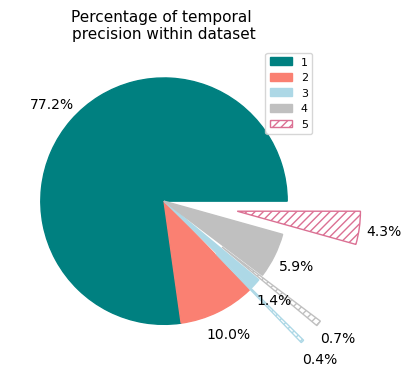

In [ ]:
#figure of data per temporal precision code
plt.figure(figsize=[6,4])
df_Kenya_tempanalysis = df_Kenya
for idx in df_Kenya_tempanalysis.index:
    df_Kenya_tempanalysis.loc[idx, 'temp_sat'] = ((df_Kenya_tempanalysis.loc[idx, 'date_prec']<=4) and (df_Kenya.loc[idx, 'date_start'].month == df_Kenya.loc[idx, 'date_end'].month))
count_Kenya_dtprec = df_Kenya_tempanalysis.groupby(['date_prec', 'temp_sat']).size()
wedges, labels, pct = plt.pie(count_Kenya_dtprec, labels=[1,2,None,3, None, 4,5], explode=(0,0,0.6,0,0.6,0,0.6), hatch=[None, None, '////', None, '////', None, '////'], colors=[colour_rng[0], colour_rng[1], 'white', colour_rng[2], 'white', colour_rng[3], 'white'], autopct="%1.1f%%", pctdistance=1.2, labeldistance=None);
wedges[0].set_edgecolor(colour_rng[0]);
wedges[1].set_edgecolor(colour_rng[1]);
wedges[2].set_edgecolor(colour_rng[2]);
wedges[3].set_edgecolor(colour_rng[2]);
wedges[4].set_edgecolor(colour_rng[3]);
wedges[5].set_edgecolor(colour_rng[3]);
wedges[6].set_edgecolor(colour_rng[5]);
plt.legend()
plt.title('Percentage of temporal \nprecision within dataset')
plt.savefig(os.path.join(path_figs, 'temp_prec_overview.png'))

### Filtering based on temporal and spatial precision

The following data cannot be clearly assigned to an administrative unit or temporal unit

- where_prec codes of 5 or higher; for data prior to 4th March 2013 also excluding where_prec code of 4
- date_prec codes of 5 and lower date_prec where overlapping more than one month




In [ ]:
df_Kenya_satprec = df_Kenya[(df_Kenya.where_prec<=4) & (df_Kenya.date_start.dt.month==df_Kenya.date_end.dt.month) & ~ ((df_Kenya.date_start<='2013-03-03')&(df_Kenya.where_prec==4))]
df_Kenya_unsatprec = df_Kenya[(df_Kenya.where_prec>4) | (df_Kenya.date_start.dt.month!=df_Kenya.date_end.dt.month) |((df_Kenya.date_start<='2013-03-03')&(df_Kenya.where_prec==4))]

In [ ]:
print(f'{len(df_Kenya_unsatprec)/len(df_Kenya)*100:.2f} % of the data got removed')

12.92 % of the data got removed


## Temporal analysis

In [ ]:
def df_to_grouped_ts(df, ct, freq):
    """
    The function transforms a given DataFrame or GeoDataFrame into an eventcount dataset per temporal unit given as freq.
    As within this code we are only interested in non-state conflict, the conflict types can be further specified as an 
    array ct by giving the corresponding numeric code.
    """
    df_ct = df[df.type_of_violence.isin(ct)]
    df_ts = df_ct.groupby(df_ct.date_start.dt.to_period(freq)).size()
    df_ts = df_ts.resample(freq, convention='end').asfreq().fillna(0)
    return df_ts

### Reporting of conflicts in Kenya over time

This section explores the temporal evolution of conflict events over time, paying special attention to whether a lot of events are excluded for that time period.

In [ ]:
#yearly event count per conflict type and whether satisfactory temporal and spatial precision codes --> in the following referred to as "satprec" vs. "unsatprec"
df_Kenya_satprec_sb = df_to_grouped_ts(df_Kenya_satprec, [1], 'Y')
df_Kenya_satprec_ns = df_to_grouped_ts(df_Kenya_satprec, [2], 'Y')
df_Kenya_satprec_os = df_to_grouped_ts(df_Kenya_satprec, [3], 'Y')

df_Kenya_unsatprec_sb = df_to_grouped_ts(df_Kenya_unsatprec, [1], 'Y')
df_Kenya_unsatprec_ns = df_to_grouped_ts(df_Kenya_unsatprec, [2], 'Y')
df_Kenya_unsatprec_os = df_to_grouped_ts(df_Kenya_unsatprec, [3], 'Y')

Text(0.5, 0, 'Year')

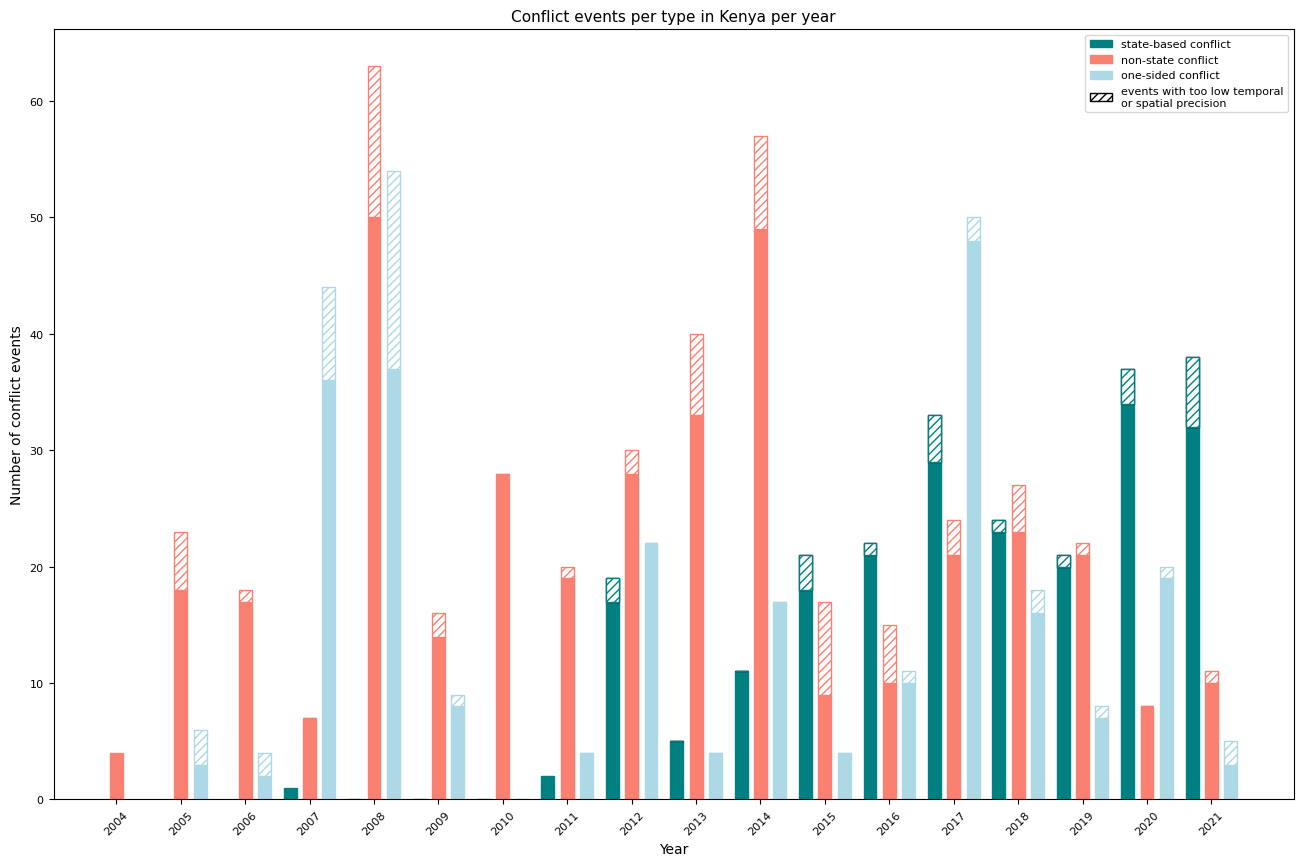

In [ ]:
#yearly event count over time as plot
plt.figure(figsize=[16,10])
x_pos1 = np.arange(len(years))-0.3 
x_pos2 = np.arange(len(years))
x_pos3 = np.arange(len(years))+0.3


plt.bar(x_pos1[df_Kenya_satprec_sb.index[0].year-years[0]:], df_Kenya_satprec_sb, width=0.2, label='state-based conflict', color=colour_rng[0], edgecolor=colour_rng[0])
plt.bar(x_pos2[df_Kenya_satprec_ns.index[0].year-years[0]:], df_Kenya_satprec_ns, width=0.2, label='non-state conflict', color=colour_rng[1], edgecolor=colour_rng[1])
plt.bar(x_pos3[df_Kenya_satprec_os.index[0].year-years[0]:], df_Kenya_satprec_os, width=0.2, label='one-sided conflict', color=colour_rng[2], edgecolor=colour_rng[2])

plt.bar(x_pos1[df_Kenya_unsatprec_sb.index[0].year-years[0]:], df_Kenya_unsatprec_sb, bottom=df_Kenya_satprec_sb[df_Kenya_unsatprec_sb.index[0].year-df_Kenya_satprec_sb.index[0].year:], width=0.2,  color='white', hatch='////', edgecolor='black', label='events with too low temporal\nor spatial precision')
plt.bar(x_pos1[df_Kenya_unsatprec_sb.index[0].year-years[0]:], df_Kenya_unsatprec_sb, bottom=df_Kenya_satprec_sb[df_Kenya_unsatprec_sb.index[0].year-df_Kenya_satprec_sb.index[0].year:], width=0.2,  color='white', hatch='////', edgecolor=colour_rng[0])
plt.bar(x_pos2[df_Kenya_unsatprec_ns.index[0].year-years[0]:], df_Kenya_unsatprec_ns, bottom=df_Kenya_satprec_ns[df_Kenya_unsatprec_ns.index[0].year-df_Kenya_satprec_ns.index[0].year:], width=0.2, color='white', hatch='////', edgecolor=colour_rng[1])
plt.bar(x_pos3[df_Kenya_unsatprec_os.index[0].year-years[0]:], df_Kenya_unsatprec_os, bottom=df_Kenya_satprec_os[df_Kenya_unsatprec_os.index[0].year-df_Kenya_satprec_os.index[0].year:], width=0.2, color='white', hatch='////', edgecolor=colour_rng[2])
plt.xticks(x_pos2, labels=years, rotation=45);

plt.legend()
plt.title('Conflict events per type in Kenya per year')
plt.ylabel('Number of conflict events')
plt.xlabel('Year')

In [ ]:
#yearly eventcount as percentage of all conflicts of that type
satprec_sb_perc = df_Kenya_satprec_sb / (df_Kenya_satprec_sb.sum() + df_Kenya_unsatprec_sb.sum())
unsatprec_sb_perc = df_Kenya_unsatprec_sb / (df_Kenya_satprec_sb.sum() + df_Kenya_unsatprec_sb.sum())
satprec_ns_perc = df_Kenya_satprec_ns / (df_Kenya_satprec_ns.sum() + df_Kenya_unsatprec_ns.sum())
unsatprec_ns_perc = df_Kenya_unsatprec_ns / (df_Kenya_satprec_ns.sum() + df_Kenya_unsatprec_ns.sum())
satprec_os_perc = df_Kenya_satprec_os / (df_Kenya_satprec_os.sum() + df_Kenya_unsatprec_os.sum())
unsatprec_os_perc = df_Kenya_unsatprec_os / (df_Kenya_satprec_os.sum() + df_Kenya_unsatprec_os.sum())

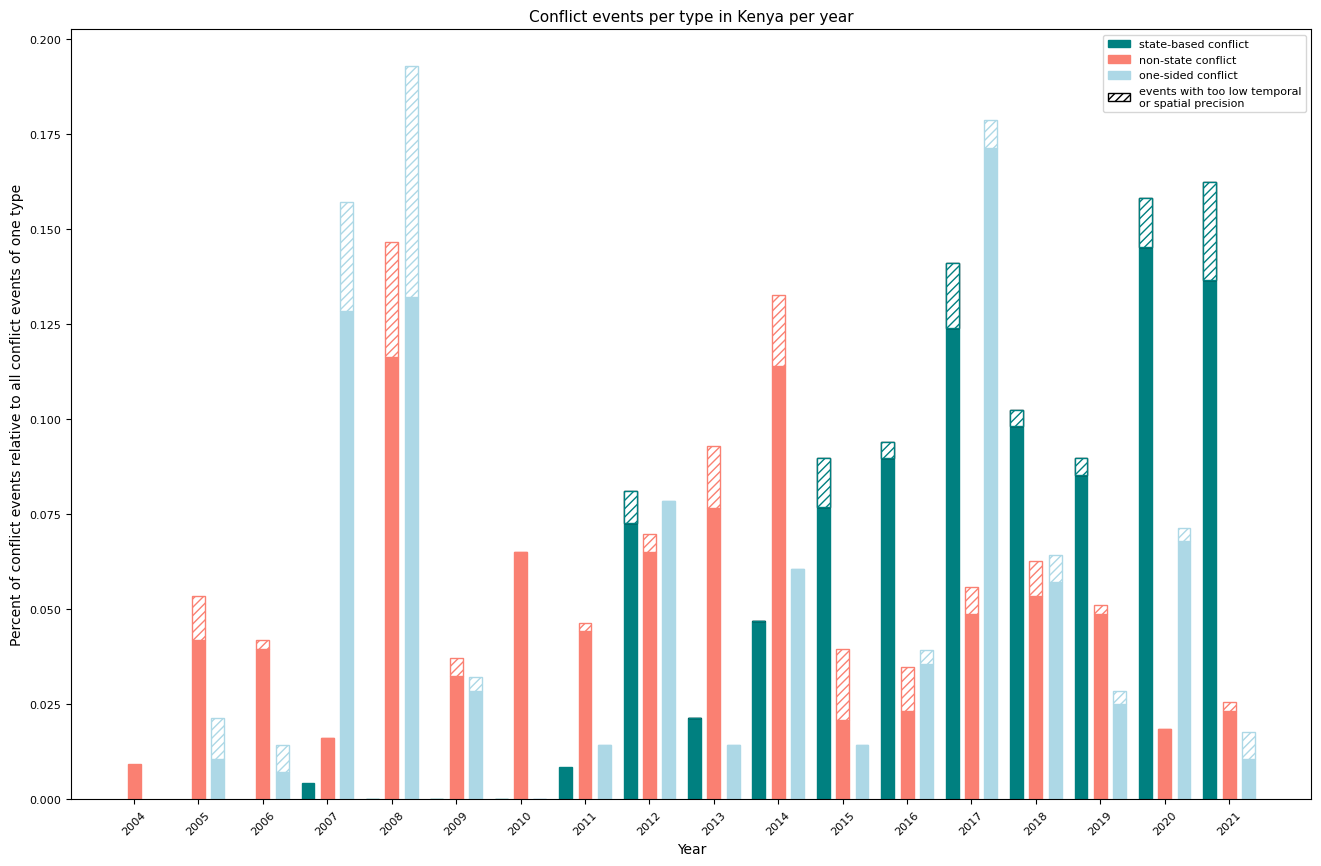

In [ ]:
#yearly event percentage over time
plt.figure(figsize=[16,10])


plt.bar(x_pos1[df_Kenya_satprec_sb.index[0].year-years[0]:], satprec_sb_perc, width=0.2, label='state-based conflict', color=colour_rng[0], edgecolor=colour_rng[0])
plt.bar(x_pos2[df_Kenya_satprec_ns.index[0].year-years[0]:], satprec_ns_perc, width=0.2, label='non-state conflict', color=colour_rng[1], edgecolor=colour_rng[1])
plt.bar(x_pos3[df_Kenya_satprec_os.index[0].year-years[0]:], satprec_os_perc, width=0.2, label='one-sided conflict', color=colour_rng[2], edgecolor=colour_rng[2])

plt.bar(x_pos1[df_Kenya_unsatprec_sb.index[0].year-years[0]:], unsatprec_sb_perc, bottom= satprec_sb_perc[df_Kenya_unsatprec_sb.index[0].year-df_Kenya_satprec_sb.index[0].year:], width=0.2,  color='white', hatch='////', edgecolor='black', label='events with too low temporal\nor spatial precision')
plt.bar(x_pos1[df_Kenya_unsatprec_sb.index[0].year-years[0]:], unsatprec_sb_perc, bottom= satprec_sb_perc[df_Kenya_unsatprec_sb.index[0].year-df_Kenya_satprec_sb.index[0].year:], width=0.2,  color='white', hatch='////', edgecolor=colour_rng[0])
plt.bar(x_pos2[df_Kenya_unsatprec_ns.index[0].year-years[0]:], unsatprec_ns_perc, bottom= satprec_ns_perc[df_Kenya_unsatprec_ns.index[0].year-df_Kenya_satprec_ns.index[0].year:], width=0.2, color='white', hatch='////', edgecolor=colour_rng[1])
plt.bar(x_pos3[df_Kenya_unsatprec_os.index[0].year-years[0]:], unsatprec_os_perc, bottom=satprec_os_perc[df_Kenya_unsatprec_os.index[0].year-df_Kenya_satprec_os.index[0].year:], width=0.2, color='white', hatch='////', edgecolor=colour_rng[2])

plt.xticks(x_pos2, labels=years, rotation=45);

plt.legend()
plt.title('Conflict events per type in Kenya per year')
plt.ylabel('Percent of conflict events relative to all conflict events of one type')
plt.xlabel('Year')
plt.savefig(os.path.join(path_figs, 'conflict_types_year_Kenya.png'))

## Analysis of bias in satprec and unsatprec data

From here on, it is primarily looked at non-state conflict as the conflict of interest.
To evaluate whether the removal of data creates any bias in the data kept, other characteristics of each event are expored:
1. the year (see above)
2. the dyad
3. the number of fatalities
4. the description provided as part of the unsatisfactory spatial precision codes
5. the type of conflict

In [ ]:
#filtering all non-state conflict data
satprec_ns = df_Kenya_satprec[df_Kenya_satprec.type_of_violence == 2]
unsatprec_ns = df_Kenya_unsatprec[df_Kenya_unsatprec.type_of_violence == 2]
ns = df_Kenya[df_Kenya.type_of_violence == 2]

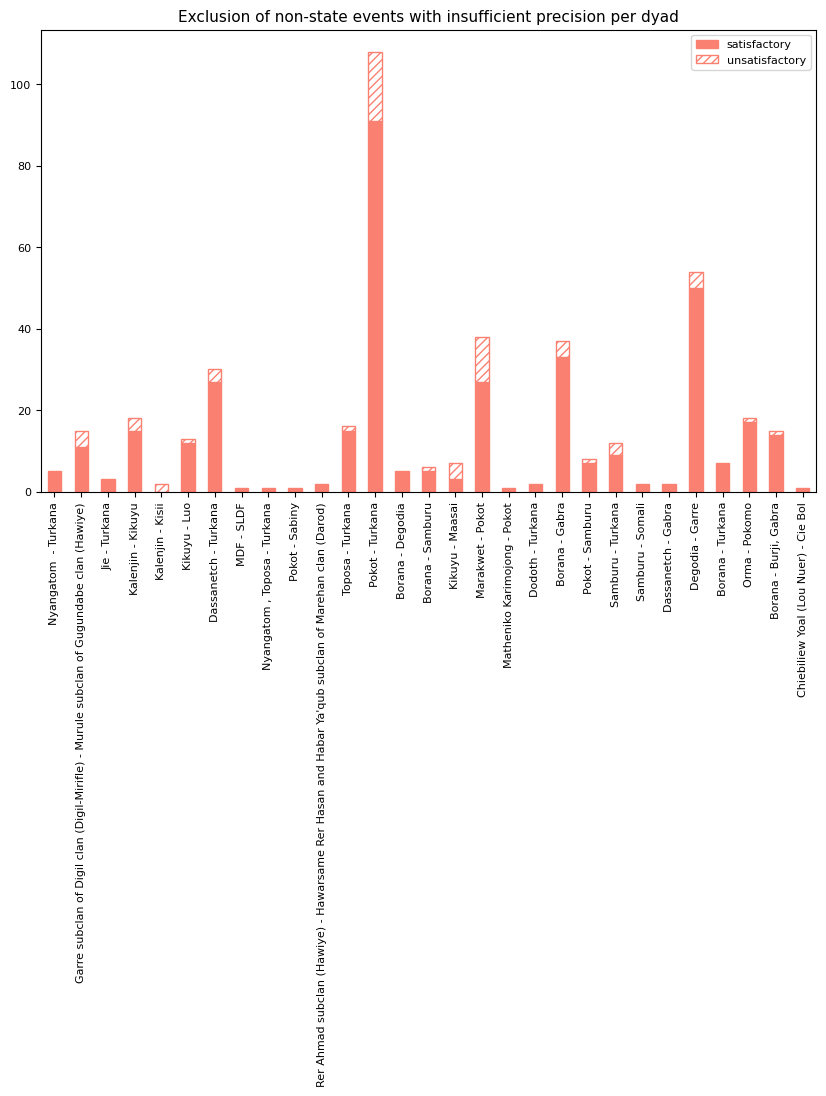

In [ ]:
#plot of conflict events per dyad
df_dyad = pd.DataFrame(index = ns.dyad_name.unique(), columns = ['satprec', 'unsatprec'])
df_dyad['unsatprec'] = unsatprec_ns.groupby('dyad_name').size()
df_dyad['satprec'] = satprec_ns.groupby('dyad_name').size()
df_dyad.fillna(0)

ax = plt.figure(figsize=[10,6]).add_subplot(111)
df_dyad.plot.bar(ax=ax, stacked=True, color=[colour_rng[1], 'white'], edgecolor=[colour_rng[1]])
bar = ax.patches
for i in np.arange(int(len(bar)/2), int(len(bar))):
    bar[i].set_hatch('////')
plt.legend(['satisfactory', 'unsatisfactory'])
plt.title('Exclusion of non-state events with insufficient precision per dyad')
plt.savefig(os.path.join(path_figs, 'dyad_precision_bias.png'))

([<matplotlib.axis.XTick at 0x273016fb190>,
 [Text(1, 0, 'satisfactory'), Text(2, 0, 'unsatisfactory')])

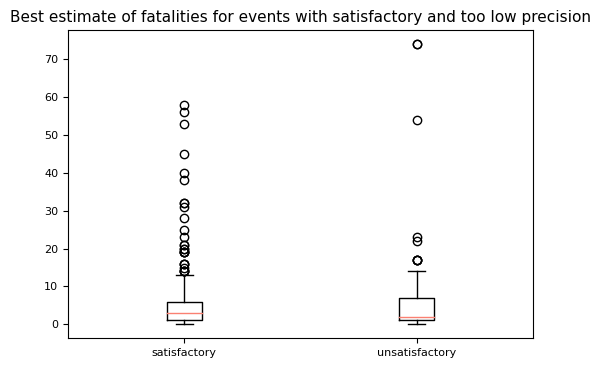

In [ ]:
#plot of the number of fatalities in satisfactory and unsatisfactory data
plt.figure(figsize=[6,4])
plt.boxplot([satprec_ns.best, unsatprec_ns.best])
plt.title('Best estimate of fatalities for events with satisfactory and too low precision')
plt.xticks(ticks=[1,2], labels=['satisfactory', 'unsatisfactory'])

In [ ]:
#spatial description of the events with unsatisfactory spatial precision codes
unsatprec_ns[((unsatprec_ns.where_prec>=5)&(unsatprec_ns.date_start >= '2013-03-03')) | ((unsatprec_ns.where_prec>=4)&(unsatprec_ns.date_start <= '2013-03-03'))].groupby('where_description').size()

where_description
Baringo-Turkana border area                                              1
Eastern region (Loyangalani area, close to Lake Turkana)                 1
Elgeyo Marakwet-West Pokot border                                        1
Embobut forest                                                           1
Ethiopia - Kenya border                                                  1
Isiolo-Samburu district border                                           1
Kamugen area                                                             1
Kerio Valley                                                             4
Lake Turkana                                                             1
Lake Turkana, on the Kenya-Ethiopia border                               1
Marakwet East - West Pokot border                                        1
Nakoriakwang village                                                     1
North Eastern province                                                   2
Pokot-T

In [ ]:
#group data by conflict type
violtype_satprec = df_Kenya_satprec.groupby('type_of_violence').size()
violtype_unsatprec = df_Kenya_unsatprec.groupby('type_of_violence').size()

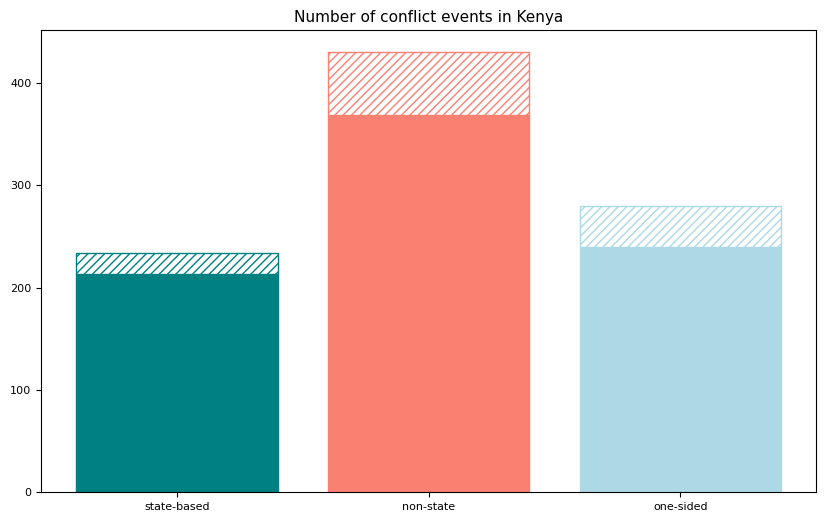

In [ ]:
#figure of conflict events of certain type in Kenya
plt.figure(figsize=[10,6])
plt.bar([1,2,3], violtype_satprec, color=colour_rng[:3], edgecolor= colour_rng[:3])
plt.bar([1,2,3], violtype_unsatprec, bottom = violtype_satprec, color='white', hatch = '////', edgecolor=colour_rng[:3])
plt.xticks([1, 2, 3], ['state-based', 'non-state', 'one-sided'])
plt.title('Number of conflict events in Kenya')
plt.savefig(os.path.join(path_figs, 'conflict_types_nr_Kenya.png'))

# Analysis of conflict data in Study Area

As part of this section an in-depth analysis of the conflict data is conducted for the study area, i.e. counties Marsabit, West Pokot and Turkana.

## Conflict type

In [ ]:
#group data by conflict type
violtype_SA_satprec = df_Kenya_satprec[(df_Kenya_satprec.adm_1.isin(['Turkana county', 'Marsabit county', 'West Pokot county'])) | (df_Kenya_satprec.adm_2.isin(['Moyale district','Turkana district', 'West Pokot district', 'Marsabit district']))].groupby('type_of_violence').size()
violtype_SA_unsatprec = df_Kenya_unsatprec[(df_Kenya_unsatprec.adm_1.isin(['Turkana county', 'Marsabit county', 'West Pokot county'])) | (df_Kenya_unsatprec.adm_2.isin(['Moyale district','Turkana district', 'West Pokot district', 'Marsabit district']))].groupby('type_of_violence').size()

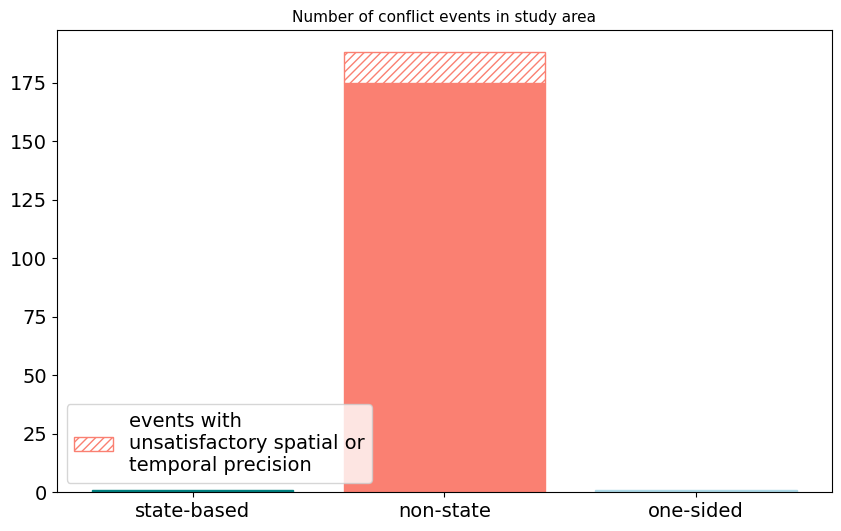

In [ ]:
#figure of conflict events of certain type in Kenya
plt.figure(figsize=[10,6])
plt.bar([1,2,3], violtype_SA_satprec, color=colour_rng[:3], edgecolor= colour_rng[:3])
plt.bar(2, violtype_SA_unsatprec, bottom = violtype_SA_satprec.iloc[1], color='white', hatch = '////', edgecolor=colour_rng[1], label='events with \nunsatisfactory spatial or\ntemporal precision')
plt.xticks([1, 2, 3], ['state-based', 'non-state', 'one-sided'])
plt.title('Number of conflict events in study area')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig(os.path.join(path_figs, 'conflict_types_nr_SA.png'))

## Clipping of conflict events to administrative units

In [ ]:
#load administrative boundaries
adm_bound = gpd.read_file(os.path.join(path_adm, 'KEN', 'gadm36_KEN.gpkg'))

In [ ]:
#dissolve administrative boundaries to admin-1 level
adm1_bound = adm_bound.dissolve(by='NAME_1').loc[:, ['GID_1', 'geometry']]

In [ ]:
#store non-state conflict locations as georeferenced points
gdf_ns_satprec = gpd.GeoDataFrame(df_Kenya_satprec[df_Kenya_satprec.type_of_violence==2], geometry=gpd.points_from_xy(df_Kenya_satprec[df_Kenya_satprec.type_of_violence==2].longitude,df_Kenya_satprec[df_Kenya_satprec.type_of_violence==2].latitude), crs='EPSG:4326')
                    

In [ ]:
#clipping data to administrative units
for county in adm1_bound.index:
    gdf_ns_county = gpd.clip(gdf_ns_satprec, adm1_bound.loc[[county]])
    gdf_ns_satprec.loc[gdf_ns_county.index, 'county'] = county #storing the respective county (current county) in dataframe

## Conflict count and conflict boolean at admin-1-monthly units

In [ ]:
#loop through the three counties to receive monthly eventcounts and no conflict/conflict variable
counties = ['Turkana', 'Marsabit', 'West Pokot']

for i in range(0,len(counties)):
    county=counties[i]
    
    #count monthly events within the
    countyspec_df_ns_county_eventcount = gdf_ns_satprec[gdf_ns_satprec.county==county].groupby([pd.Grouper(key='date_start', freq='M'), 'county']).size().unstack()
    
    #fill monthly eventcount to full time period of investigation
    first_months = pd.DataFrame(index=pd.date_range('2004-01-31', str(countyspec_df_ns_county_eventcount.index[0] - relativedelta(months=1)), freq='M'), columns=countyspec_df_ns_county_eventcount.columns)
    last_months = pd.DataFrame(index=pd.date_range(str(countyspec_df_ns_county_eventcount.index[-1] + relativedelta(months=1)), '2021-12-31', freq='M'), columns=countyspec_df_ns_county_eventcount.columns)
    countyspec_df_ns_county_eventcount = pd.concat([first_months, countyspec_df_ns_county_eventcount, last_months])
    countyspec_df_ns_county_eventcount = countyspec_df_ns_county_eventcount.resample('M').asfreq().fillna(0).stack()
    
    #concatenate dfs for all three counties
    if i == 0:
        df_ns_county_eventcount = countyspec_df_ns_county_eventcount.copy()
    else:
        df_ns_county_eventcount = pd.concat([df_ns_county_eventcount, countyspec_df_ns_county_eventcount])
        
#derive binary conflict occurrence variable from continuous conflict variable
df_ns_county_eventbool = df_ns_county_eventcount>0


In [ ]:
#yearly eventcounts per county
df_ns_county_eventcount = pd.DataFrame(df_ns_county_eventcount).reset_index(level=1)
df_ns_sa_eventcount = df_ns_county_eventcount[df_ns_county_eventcount.county.isin(['Turkana', 'Marsabit', 'West Pokot'])]
df_ns_sa_yearly_eventcount = df_ns_sa_eventcount.groupby([df_ns_sa_eventcount.index.year, 'county']).sum()
df_ns_sa_yearly_eventcount = df_ns_sa_yearly_eventcount.reset_index(level=1)
df_ns_Marsabit_yearly_eventcount = df_ns_sa_yearly_eventcount[df_ns_sa_yearly_eventcount.county=='Marsabit']
df_ns_Turkana_yearly_eventcount = df_ns_sa_yearly_eventcount[df_ns_sa_yearly_eventcount.county=='Turkana']
df_ns_WP_yearly_eventcount = df_ns_sa_yearly_eventcount[df_ns_sa_yearly_eventcount.county=='West Pokot']

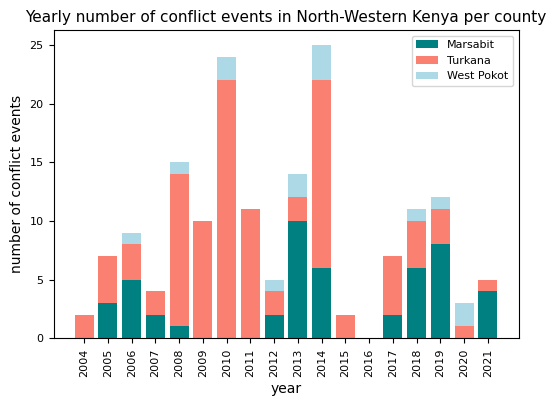

In [ ]:
#plot of yearly eventcounts per county
plt.bar(df_ns_Marsabit_yearly_eventcount.index, df_ns_Marsabit_yearly_eventcount[0], label='Marsabit')
plt.bar(df_ns_Turkana_yearly_eventcount.index, df_ns_Turkana_yearly_eventcount[0], bottom=df_ns_Marsabit_yearly_eventcount[0], label='Turkana')
plt.bar(df_ns_WP_yearly_eventcount.index, df_ns_WP_yearly_eventcount[0], bottom=df_ns_Marsabit_yearly_eventcount[0]+df_ns_Turkana_yearly_eventcount[0], label='West Pokot')
plt.legend()
plt.xticks(ticks=np.arange(2004, 2022), rotation=90)
plt.xlabel('year')
plt.ylabel('number of conflict events')
plt.title('Yearly number of conflict events in North-Western Kenya per county')
plt.savefig(os.path.join(path_figs, 'yearly_conflictevents_SA.svg'))

In [ ]:
#number of conflict months per year and county in study area
df_ns_county_eventbool = pd.DataFrame(df_ns_county_eventbool).reset_index(level=1)
df_ns_sa_eventbool = df_ns_county_eventbool[df_ns_county_eventbool.county.isin(['Turkana', 'Marsabit', 'West Pokot'])]
df_ns_sa_yearly_eventbool = df_ns_sa_eventbool.groupby([df_ns_sa_eventbool.index.year, 'county']).sum()
df_ns_sa_yearly_eventbool = df_ns_sa_yearly_eventbool.reset_index(level=1)
df_ns_Marsabit_yearly_eventbool = df_ns_sa_yearly_eventbool[df_ns_sa_yearly_eventbool.county=='Marsabit']
df_ns_Turkana_yearly_eventbool = df_ns_sa_yearly_eventbool[df_ns_sa_yearly_eventbool.county=='Turkana']
df_ns_WP_yearly_eventbool = df_ns_sa_yearly_eventbool[df_ns_sa_yearly_eventbool.county=='West Pokot']

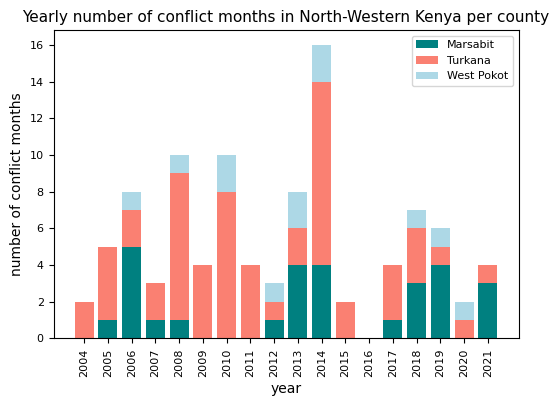

In [ ]:
#plot of number of conflict months per year and county in study area
plt.bar(df_ns_Marsabit_yearly_eventbool.index, df_ns_Marsabit_yearly_eventbool[0], label='Marsabit')
plt.bar(df_ns_Turkana_yearly_eventbool.index, df_ns_Turkana_yearly_eventbool[0], bottom=df_ns_Marsabit_yearly_eventbool[0], label='Turkana')
plt.bar(df_ns_WP_yearly_eventbool.index, df_ns_WP_yearly_eventbool[0], bottom=df_ns_Marsabit_yearly_eventbool[0]+df_ns_Turkana_yearly_eventbool[0], label='West Pokot')
plt.legend()
plt.xticks(ticks=np.arange(2004, 2022), rotation=90)
plt.xlabel('year')
plt.ylabel('number of conflict months')
plt.title('Yearly number of conflict months in North-Western Kenya per county')
plt.savefig(os.path.join(path_figs, 'yearly_conflictmonths_SA.svg'))

In [ ]:
#table of total number of conflicts and conflict months per administrative unit
#set up table
df_comparison = pd.DataFrame(index = ['number of events', 'number of conflict months'], columns=['Marsabit', 'Turkana', 'West Pokot'])

#fill table
df_comparison.iloc[0,0] = df_ns_Marsabit_yearly_eventcount.loc[:,0].sum()
df_comparison.iloc[1,0] = df_ns_Marsabit_yearly_eventbool.loc[:,0].sum()
df_comparison.iloc[0,1] = df_ns_Turkana_yearly_eventcount.loc[:,0].sum()
df_comparison.iloc[1,1] = df_ns_Turkana_yearly_eventbool.loc[:,0].sum()
df_comparison.iloc[0,2] = df_ns_WP_yearly_eventcount.loc[:,0].sum()
df_comparison.iloc[1,2] = df_ns_WP_yearly_eventbool.loc[:,0].sum()

display(df_comparison)

,Marsabit,Turkana,West Pokot
number of events,49,103,14
number of conflict months,28,58,12
